### 這個Notebook是我在學習A/B test時的隨行筆記，用來紀錄用Python做A/B test時的各項步驟。
主要紀錄幾個重點：
- 什麼是A/B test
    - A/B test 是一種在網頁或者產品分析，特別是電子商務網站常用的手法，主要是將想確確認的變因或假說分成Ａ組和Ｂ組並將客戶群隨機分流到兩組之中，藉此分析兩組區別，最終目的是選擇成績較好的版本。
- A/B test 的實行步驟
    - A/B test 主要分成幾個步驟，分別是：
       1. 確立目標
       2. 提出假設
       3. 搜集資料，進行測試
       4. 得出結論，選擇版本或繼續提出假設

使用資料集 : Kaggle's Data Source - Grocery website data for AB test:
https://www.kaggle.com/tklimonova/grocery-website-data-for-ab-test

### Step 1: 確立目標 : 提高轉換率
#### A/B Test 的目標通常分為兩大類：
    1. 提升Ｘ：
        Example: 點擊率，轉換率，訂閱人數，註冊率...
    2. 降低Ｙ：
        Example: 客戶流失率，取消訂閱率...
Note: A/B Test 的目標需要盡量簡潔明確且可量化。

這次我設定的目標情境是希望可以增加客戶點擊公司網頁的忠誠度計畫頁面機率（也就是轉換率）

### Step 2: 提出假設 : 新版本的轉換率是否能比舊版本提高2%
這個步驟在實作上應和前線人員溝通要調整的方案假設，一般都是頁面內容的更動，像是：
- 文案    ： 標題、價值傳遞、商品描述...
- 版面配置 ： 板塊位置、顏色...
- 促銷方案 ： 不同價位、折扣...

這次是使用Kaggle的資料進行模擬實驗，所以我將ServerID = 1 設為Ａ（新版本）組，ServerID = 2 or 3 設為Ｂ（舊版本）組。

#### 這邊由於我提出的假設是希望網頁能從目前的5%轉換率提高到7%，為了保證樣本數不會太小影響顯著性，也不會太大導致取得成本過高，因此我使用Power Analysis尋找所需的樣本數
- 什麼是Power Analysis以及為何要使用它?
    - Power Analysis通常在數據收集之前進行，主要目的是幫助研究人員確定適合檢測給定測試在所需顯著性水平上的影響的最小樣本量。較大的樣本可以讓數據更接近0.05的顯著性水平，同時避免研究人員因為樣本數太小犯下第二類錯誤。而在理想情況下，研究人員需要較小的樣本，因為較大的樣本通常比較小的樣本成本更高。較小的樣本也優化了顯著性檢驗。Power Analysis正是用來取得這兩者之間的平衡。

In [1]:
# Packages imports
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.05, 0.07)    

#Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  

# Rounding up to next whole number   
required_n = ceil(required_n)                               

print('所需樣本數：{}'.format(required_n))

所需樣本數：2199


### Step 3： 搜集資料，進行測試

### Data View
- RecordID     : identifier of the row of data
- IP Address   : address of the user, who is visiting website
- LoggedInFlag : 1 - when user has an account and logged in
- ServerID     : one of the servers user was routed through (Where we grouping)
- VisitPageFlag: 1 - when user clicked on the loyalty program page (Conversion Rate)

In [2]:
import pandas as pd

df = pd.read_csv('grocerywebsiteabtestdata.csv')
df.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [3]:
df.shape

(184588, 5)

In [4]:
df.info() #It doesn't have null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184588 entries, 0 to 184587
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   RecordID       184588 non-null  int64 
 1   IP Address     184588 non-null  object
 2   LoggedInFlag   184588 non-null  int64 
 3   ServerID       184588 non-null  int64 
 4   VisitPageFlag  184588 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 7.0+ MB


In [5]:
df.groupby('ServerID')[['LoggedInFlag','VisitPageFlag']].mean() 

,LoggedInFlag,VisitPageFlag
ServerID,,
1,0.504570,0.067640
2,0.510779,0.053300
3,0.495628,0.053596


### Grouping

In [6]:
df['Group'] = ['Treatment' if v==1 else 'Control' for v in df['ServerID']]
df.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag,Group
0,1,39.13.114.2,1,2,0,Control
1,2,13.3.25.8,1,1,0,Treatment
2,3,247.8.211.8,1,1,0,Treatment
3,4,124.8.220.3,0,3,0,Control
4,5,60.10.192.7,0,2,0,Control


### Sample

In [12]:
control_sample = df[df['Group']=='Control'].sample(n=int(2*required_n), random_state=121)
treatment_sample = df[df['Group']=='Treatment'].sample(n=int(2*required_n), random_state=121)

ab_test = pd.concat([control_sample,treatment_sample],axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag,Group
0,61036,168.5.11.5,0,3,0,Control
1,14088,151.8.38.2,0,2,0,Control
2,15621,28.2.88.6,1,3,0,Control
3,100190,227.7.180.2,1,3,0,Control
4,25061,125.13.154.3,1,3,0,Control
...,...,...,...,...,...,...
8791,172423,248.6.106.6,1,1,0,Treatment
8792,80308,207.7.49.4,1,1,0,Treatment
8793,67917,171.7.78.6,1,1,0,Treatment
8794,160118,223.16.193.3,0,1,0,Treatment


In [13]:
ab_test['Group'].value_counts()

Control      4398
Treatment    4398
Name: Group, dtype: int64

### Calculate the Conversion Rate by Group

In [14]:
conversion_rate = ab_test.groupby('Group')['VisitPageFlag']
std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rate = conversion_rate.agg([np.mean, std_p, se_p])
conversion_rate.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rate.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
Group,,,
Control,0.056,0.229,0.003
Treatment,0.073,0.260,0.004


### Visualization

Text(0, 0.5, 'Conversion Rate')

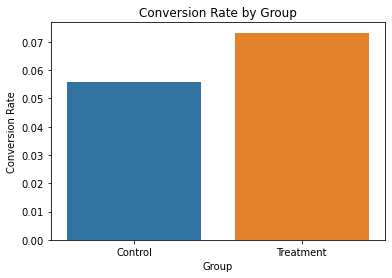

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=ab_test['Group'], y=ab_test['VisitPageFlag'], ci=False)
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')

### Testing the hypothesis

In [16]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['Group'] == 'Control']['VisitPageFlag']
treatment_results = ab_test[ab_test['Group'] == 'Treatment']['VisitPageFlag']
n_con = control_results.count()
n_treat = treatment_results.count()
success = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(success, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(success, nobs=nobs, alpha=0.05)

print('z statistic: {:.2f}'.format(z_stat))
print('p-value: {:.2f}'.format(pval))
print(f'ci 95% for control group: ', list(map('{:.2f}%'.format, [lower_con, upper_con])))
print(f'ci 95% for treatment group: ', list(map('{:.2f}%'.format, [lower_treat, upper_treat])))

z statistic: -3.34
p-value: 0.00
ci 95% for control group:  ['0.05%', '0.06%']
ci 95% for treatment group:  ['0.07%', '0.08%']


### Step 4: 得出結論
舊版本組和新版本組的95%信心區間發現舊版本組的轉換率在5%-7%，對照組則是在6%-8%
- 新版本的數據並沒有包含基礎轉換率5%
- 新版的的轉換率區間有到達設定轉換率7%
- P-value = 0.00 < α = 0.05 :代表這項結果在統計學上具有顯著性

這代表新版本的轉換率在統計學上可能如我們期望的有提升2%達到7%。

### 筆記總結
- 使用Power Analysis初步得到的樣本數量算出來的p-value = 0.16在統計學上並不具備顯著性意義所以緩慢提高直到1.25倍的樣本數量才得到p-value = 0.02，信心區間從[5%-6%]提升到[6%-8%]雖然有所提升但兩者間重疊性大。當樣本數達到2倍時信心區間則有明顯區別且p-value=0.00。A/B test本就需要不斷監控直到統計具有顯著意義為止。